In [ ]:
pip install watson-developer-cloud

In [ ]:
pip install pyLDAvis

In [9]:
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import watson_developer_cloud
from botocore.client import Config
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import urllib
from bs4 import BeautifulSoup
import requests
import nltk
import operator

#nltk.download('all')

In [10]:
'''Get the summary of the text'''

def get_summary(text, pct):
    summary = summarize(text,ratio=pct,split=True)
    return summary

'''Get the keywords of the text'''

def get_keywords(text):
    res = keywords(text, ratio=0.1, words=None, split=False, scores=False, pos_filter=('NN', 'JJ'), lemmatize=False, deacc=False)
    res = res.split('\n')
    return res

'''Tokenize the sentence into words & remove punctuation'''

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def extract_title_text(url):
    page = urllib.request.urlopen(url).read().decode('utf8')
    soup = BeautifulSoup(page,'lxml')
    text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
    return soup.title.text, text

In [34]:
import pandas as pd

In [ ]:
data = pd.read_excel(r'C:\Users\ehu\repos\dna\NLP Projects\COVID NLP.xlsx', sheet_name='Grid')
text1 = []
for i in range(len(data['Sentence'])):
    text1.append(data['Sentence'][i])
text = ' '.join(text1)
text

In [11]:
# text = 'Experimental Treatment with Favipiravir for COVID-19: An Open-Label Control Study. An outbreak of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) infection and its caused coronavirus disease 2019 (COVID-19) has been reported in China since December 2019. More than 16% of patients developed acute respiratory distress syndrome, and the fatality ratio was about 1%-2%. No specific treatment has been reported. Herein, we examine the effects of Favipiravir (FPV) versus Lopinavir (LPV)/ritonavir (RTV) for the treatment of COVID-19. Patients with laboratory-confirmed COVID-19 who received oral FPV (Day 1: 1600 mg twice daily; Days 2-14: 600 mg twice daily) plus interferon (IFN)-alpha by aerosol inhalation (5 million U twice daily) were included in the FPV arm of this study, whereas patients who were treated with LPV/RTV (Days 1-14: 400 mg/100 mg twice daily) plus IFN-alpha by aerosol inhalation (5 million U twice daily) were included in the control arm. Changes in chest computed tomography (CT), viral clearance, and drug safety were compared between the two groups. For the 35 patients enrolled in the FPV arm and the 45 patients in the control arm, all baseline characteristics were comparable between the two arms. A shorter viral clearance time was found for the FPV arm versus the control arm (median (interquartile range, IQR), 4 (2.5-9) d versus 11 (8-13) d, P < 0.001). The FPV arm also showed significant improvement in chest imaging compared with the control arm, with an improvement rate of 91.43% versus 62.22% (P = 0.004). After adjustment for potential confounders, the FPV arm also showed a significantly higher improvement rate in chest imaging. Multivariable Cox regression showed that FPV was independently associated with faster viral clearance. In addition, fewer adverse reactions were found in the FPV arm than in the control arm. In this open-label nonrandomized control study, FPV showed significantly better treatment effects on COVID-19 in terms of disease progression and viral clearance; if causal, these results should be important information for establishing standard treatment guidelines to combat the SARS-CoV-2 infection.'

In [45]:
pm_summary = get_summary(text, 0.4)

In [46]:
text = pm_summary

In [47]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ehu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ehu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
import re
text = re.sub('[^ a-zA-Z0-9]', '', str(text))
stop_words = set(stopwords.words('english'))
stop_words.update(['Prothena', 'PM', 'LC', 'SR', 'DVDH', 'noted', 'suggested', 'asked', 'stressed', 'may', 'eg'])
lemma = WordNetLemmatizer()
word_tokens = word_tokenize(str(text)) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)

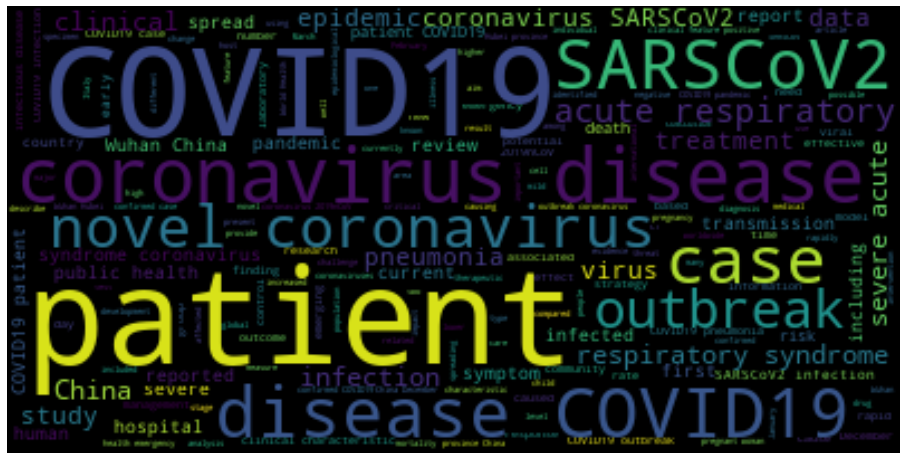

In [50]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(normalized)
plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
count = {}
for w in normalized.split():
    if w in count:
        count[w] += 1
    else:
        count[w] = 1
for word, times in count.items():
    if times > 3:
        print("%s was found %d times" % (word, times))
sorted_count = dict(sorted(count.items(), key=operator.itemgetter(1), reverse=True)[:15])

In [52]:
sorted_count.keys()

dict_keys(['COVID19', 'coronavirus', 'patient', 'disease', 'SARSCoV2', '2019', 'The', 'case', 'China', 'infection', 'clinical', 'respiratory', 'outbreak', 'severe', 'novel'])

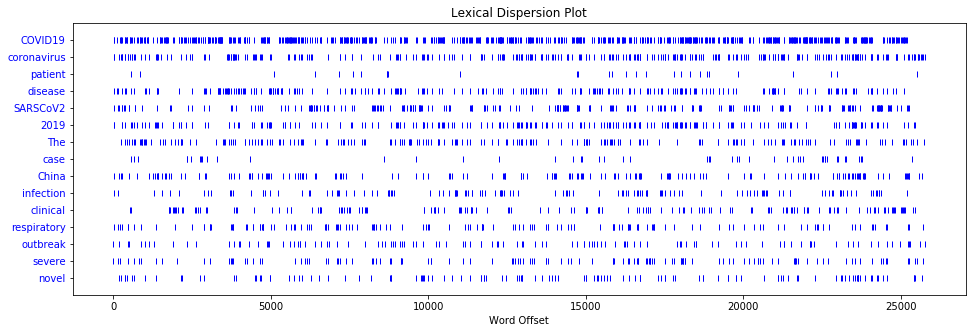

In [53]:
tokens = nltk.word_tokenize(text)
content = nltk.Text(tokens)
plt.figure(figsize=(16,5))
topics = list(sorted_count.keys())
content.dispersion_plot(topics)

#### Topic Modelling

In [54]:
tokenized_sents = list(sent_to_words(filtered_sentence))

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_sents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_sents]

In [55]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix by selecting minimum parameters required.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=100)

In [56]:
print(ldamodel.print_topics(num_topics=5, num_words=10))

[(0, '0.107*"coronavirus" + 0.076*"patients" + 0.037*"severe" + 0.032*"outbreak" + 0.026*"syndrome" + 0.016*"public" + 0.014*"ct" + 0.013*"care" + 0.011*"viral" + 0.009*"world"'), (1, '0.037*"cases" + 0.026*"acute" + 0.025*"wuhan" + 0.023*"treatment" + 0.019*"virus" + 0.017*"confirmed" + 0.016*"data" + 0.016*"study" + 0.014*"spread" + 0.013*"emergency"'), (2, '0.156*"covid" + 0.045*"china" + 0.041*"novel" + 0.039*"respiratory" + 0.029*"pneumonia" + 0.019*"pandemic" + 0.015*"characteristics" + 0.014*"reported" + 0.013*"including" + 0.011*"hospital"'), (3, '0.072*"sarscov" + 0.072*"disease" + 0.049*"clinical" + 0.038*"health" + 0.036*"infection" + 0.012*"global" + 0.011*"report" + 0.011*"countries" + 0.011*"december" + 0.010*"current"'), (4, '0.048*"the" + 0.018*"we" + 0.015*"case" + 0.014*"transmission" + 0.014*"epidemic" + 0.014*"caused" + 0.013*"ncov" + 0.012*"in" + 0.011*"early" + 0.010*"symptoms"')]


In [57]:
'''Compute Perplexity'''

# a measure of how good the model is. lower the better.

print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

'''Compute Coherence Score'''

coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized_sents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.517478303194549

Coherence Score:  0.8427263763172632


In [58]:
'''Visualize the topics'''
# pyLDAvis tool to visualize the fit of our LDA model across topics and their top words. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.306144 -0.106398       1        1  20.286736
1     -0.039224  0.111213       2        1  20.092285
4     -0.021930  0.034553       3        1  20.090858
3     -0.051304  0.211180       4        1  19.781464
2     -0.193685 -0.250548       5        1  19.748652, topic_info=     Category        Freq         Term       Total  loglift  logprob
11    Default  510.000000        covid  510.000000  30.0000  30.0000
6     Default  359.000000  coronavirus  359.000000  29.0000  29.0000
16    Default  255.000000     patients  255.000000  28.0000  28.0000
7     Default  236.000000      sarscov  236.000000  27.0000  27.0000
10    Default  234.000000      disease  234.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
389    Topic5   15.071617     analysis   15.739751   1.5787  -5.3767
1424   Topic5   14.556040         host   15.224191   1.5772  -5.4116
615    Topic5   14.299198      chinese   14.967344   1.5764  -5.4294
542    Topic5   13.798835          who   14.466966   1.5748  -5.4650
164    Topic5   13.565008      options   14.233143   1.5740  -5.4821

[180 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         2  0.991771      acute
92        5  0.950128   affected
359       4  0.925389        aim
294       2  0.975227       also
79        3  0.952117      among
...     ...       ...        ...
866       5  0.969812      women
664       3  0.938813    workers
115       1  0.976124      world
200       2  0.968292  worldwide
72        2  0.987877      wuhan

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])